In [1]:
from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


In [2]:
# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data/H_EURO2020", "DEN")
one_match = extract_one_match(data, 1)
mean_xy = calculate_xy_mean(one_match.iloc[::48].filter(regex="^home").to_numpy())


[[ 5.249e+01 -8.000e-02  1.996e+01 ...  9.080e+00  1.504e+01  1.086e+01]
 [ 5.037e+01 -4.000e-02  2.069e+01 ...  3.980e+00  1.469e+01  1.118e+01]
 [ 4.646e+01  5.600e-01  2.350e+01 ... -1.660e+00  1.879e+01  1.298e+01]
 ...
 [ 4.947e+01  1.700e-01  3.926e+01 ...  1.879e+01  3.206e+01  3.670e+00]
 [ 4.855e+01  7.000e-02  3.669e+01 ...  1.590e+01  2.930e+01 -1.330e+00]
 [ 4.851e+01  1.180e+00  3.459e+01 ...  1.482e+01  2.714e+01 -3.490e+00]]


['home_14_' 'home_18_' 'home_1_' 'home_20_' 'home_23_' 'home_3_' 'home_4_'
 'home_5_' 'home_6_' 'home_8_' 'home_9_']


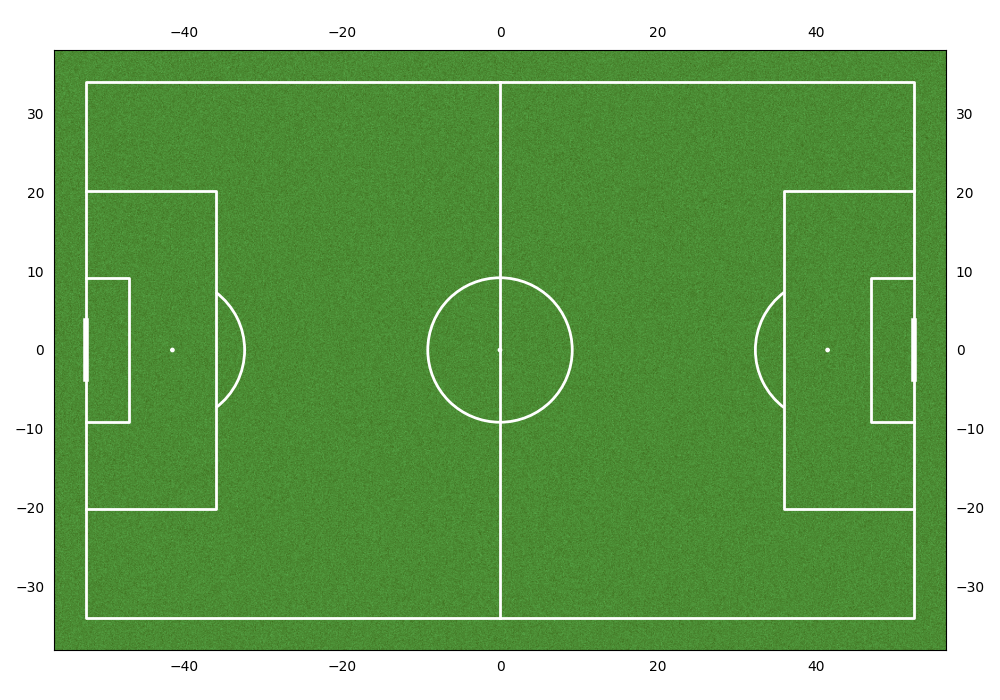

Situation saved! Total saved situations: 1
[np.str_('home_14_')]
[np.str_('home_14_'), np.str_('home_18_')]
[np.str_('home_14_'), np.str_('home_18_'), np.str_('home_1_')]
[np.str_('home_14_'), np.str_('home_18_'), np.str_('home_1_'), np.str_('home_20_')]
[np.str_('home_14_'), np.str_('home_18_'), np.str_('home_1_'), np.str_('home_20_'), np.str_('home_23_')]
[np.str_('home_14_'), np.str_('home_18_'), np.str_('home_1_'), np.str_('home_20_'), np.str_('home_23_'), np.str_('home_3_')]
[np.str_('home_14_'), np.str_('home_18_'), np.str_('home_1_'), np.str_('home_20_'), np.str_('home_23_'), np.str_('home_3_'), np.str_('home_4_')]
[np.str_('home_14_'), np.str_('home_18_'), np.str_('home_1_'), np.str_('home_20_'), np.str_('home_23_'), np.str_('home_3_'), np.str_('home_4_'), np.str_('home_5_')]
[np.str_('home_14_'), np.str_('home_18_'), np.str_('home_1_'), np.str_('home_20_'), np.str_('home_23_'), np.str_('home_3_'), np.str_('home_4_'), np.str_('home_5_'), np.str_('home_6_')]
[np.str_('home_14_')

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import ipywidgets as widgets
from IPython.display import display

# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# List to store points for the current situation and vectors
players =[]
points = []
vectors = []
situations = []

# Boolean to check if we're in vector drawing mode
draw_vector_mode = False
vector_start = None  # To store the start point of the vector

# Function to handle mouse clicks for points and vectors
def on_click(event):
    global vector_start, draw_vector_mode
    
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        
        if draw_vector_mode:
            if vector_start is None:  # If no start point, set this as start point
                vector_start = (x, y)
                ax.plot(x, y, 'bo')  # Mark the start point with a blue dot
            else:
                # If there's already a start point, draw the vector from start to this point
                vector_end = (x, y)
                ax.annotate('', xy=vector_end, xytext=vector_start,
                            arrowprops=dict(facecolor='red', shrink=0.05))  # Draw vector
                vectors.append((vector_start, vector_end))  # Save the vector
                vector_start = None  # Reset the start point
        else:
            points.append((x, y))  # Add to list of points
            ax.plot(x, y, 'ro')  # Plot the point
        
        plt.draw()  # Redraw the figure

# Function to save the current situation
def save_situation(_):
    if points or vectors:
        situations.append({'points': list(points), 'vectors': list(vectors)})  # Save the current points and vectors
        print(f"Situation saved! Total saved situations: {len(situations)}")
    else:
        print("No players or vectors to save!")

# Function to clear the current situation
def clear_situation(_):
    global points, vectors, vector_start
    points = []  # Clear the current points
    vectors = []  # Clear the current vectors
    vector_start = None  # Reset vector start point
    ax.cla()  # Clear the plot
    football_pitch.draw(ax=ax)  # Redraw the empty pitch
    plt.draw()
    print("Cleared the current situation. You can now draw a new one.")

# Function to toggle vector drawing mode
def toggle_draw_vector(_):
    global draw_vector_mode
    draw_vector_mode = not draw_vector_mode  # Toggle the mode
    if draw_vector_mode:
        print("Vector drawing mode enabled. Select start and end points for the vector.")
    else:
        print("Switched to player drawing mode.")

def select_player(player_num):
    players.append(player_num)
    print(players)

def remove_player(player_num):
    try:
        players.remove(player_num)
        print(players)
    except:
        print("Player not in list")

# Create save, clear, and toggle vector buttons
save_button = widgets.Button(description="Save Situation", button_style='success')
clear_button = widgets.Button(description="Clear", button_style='warning')
toggle_vector_button = widgets.Button(description="Toggle Draw Vector", button_style='info')

#Create buttons for player filter
buttons = []
#Get unique players
players_xy = one_match.filter(regex="^home").columns.to_numpy()
player_numbers = np.array([player[:-1] for player in players_xy])
player_numbers = np.unique(player_numbers)
print(player_numbers)

for number in player_numbers:
    save_button_player = widgets.Button(description=str(number))
    undo_button = widgets.Button(description="remove player "+str(number))
    save_button_player.on_click(lambda _, n=number: select_player(n))
    undo_button.on_click(lambda _, n=number: remove_player(n))
    buttons.append(save_button_player)
    buttons.append(undo_button)
    




# Connect button click events to their functions
save_button.on_click(save_situation)
clear_button.on_click(clear_situation)
toggle_vector_button.on_click(toggle_draw_vector)
buttons.append(save_button)
buttons.append(clear_button)
buttons.append(toggle_vector_button)

# Display the buttons below the plot
display(widgets.HBox(buttons))

# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()


In [4]:
regex = ""
for player in players:
    regex += "^"+player + "|" 
regex = regex[:-1]


#one_match = one_match.filter(regex = regex)
print(one_match.columns)

Index(['Time [s]', 'frame_team', 'Time [s]_team', 'half_team', 'home_1_x',
       'home_1_y', 'home_3_x', 'home_3_y', 'home_4_x', 'home_4_y', 'home_5_x',
       'home_5_y', 'home_6_x', 'home_6_y', 'home_8_x', 'home_8_y', 'home_9_x',
       'home_9_y', 'home_14_x', 'home_14_y', 'home_18_x', 'home_18_y',
       'home_20_x', 'home_20_y', 'home_23_x', 'home_23_y', 'ball_x_team',
       'ball_y_team', 'Period_team', 'frame', 'half', 'away_2_x', 'away_2_y',
       'away_3_x', 'away_3_y', 'away_7_x', 'away_7_y', 'away_11_x',
       'away_11_y', 'away_13_x', 'away_13_y', 'away_14_x', 'away_14_y',
       'away_15_x', 'away_15_y', 'away_16_x', 'away_16_y', 'away_17_x',
       'away_17_y', 'away_22_x', 'away_22_y', 'away_23_x', 'away_23_y',
       'ball_x', 'ball_y', 'Period'],
      dtype='object')


Collected 11 points.


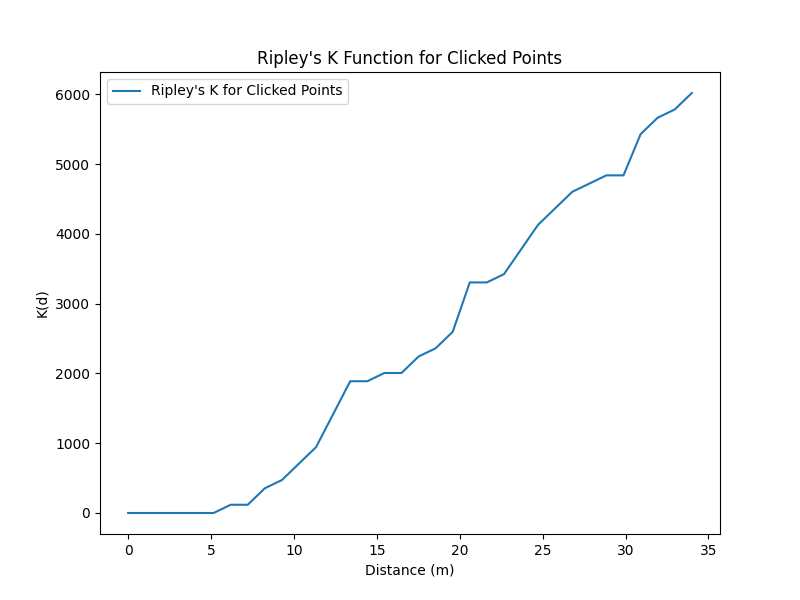

In [5]:
# Ensure the interactive pitch has captured points
if not points:
    print("Please click on the pitch to add points.")
else:
    print(f"Collected {len(points)} points.")

# Step 2: Convert the points from the interactive pitch into a usable format
points_array = np.array(points)  # Convert the collected points into a NumPy array

if points_array.shape[0] > 1:
    # Flatten the points for Ripley's K
    points_series = pd.Series(points_array.flatten())

    # Step 3: Define the radii for Ripley's K
    radii = np.linspace(0, 34, 34)  # Adjust the range based on your use case

    # Step 4: Calculate Ripley's K for the clicked points
    k_values_clicked = ripley_k(points_series, radii, width=105.0, height=68.0)

    # Step 5: Plot Ripley's K values for the clicked points
    plt.figure(figsize=(8, 6))
    plt.plot(radii, k_values_clicked, label="Ripley's K for Clicked Points")
    plt.xlabel('Distance (m)')
    plt.ylabel("K(d)")
    plt.title("Ripley's K Function for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [ ]:
# Step 7: Calculate Ripley's K values for the real match data
ripley_k_vals = ripley_k_by_indices(one_match, one_match.iloc[::48].index)
ripley_k_vals = np.hstack((ripley_k_vals, mean_xy))

#Added average position of team as feature

# Step 8: Perform PCA on the Ripley's K values from the real match data
pca_obj_ripley = PCAObject(ripley_k_vals, 10)  # Fit PCA with 10 components
np_pca_ripley = pca_obj_ripley.transform(ripley_k_vals)




# Step 9: Plot the PCA-reduced Ripley's K values for the real match
plt.figure()
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1])
plt.title("PCA of Ripley's K for Real Match")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("pca_ripley.png")
plt.show()

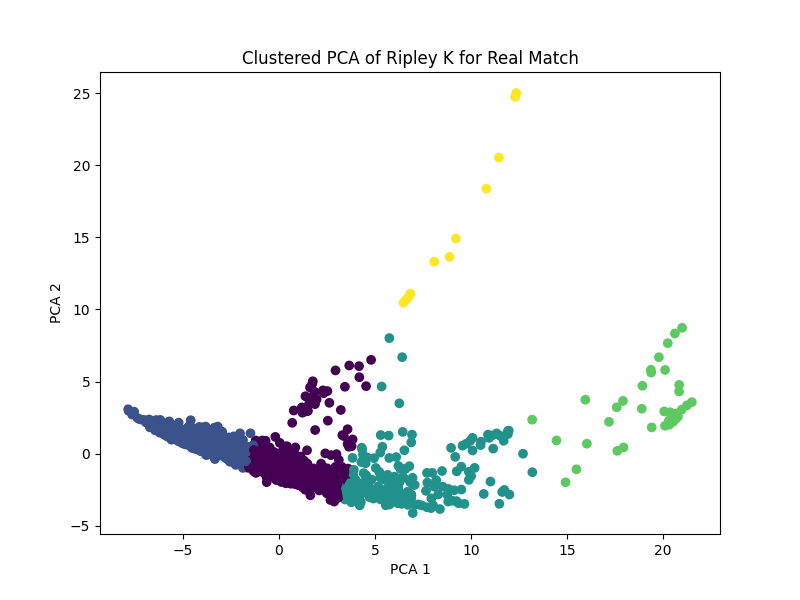

In [6]:
# Step 10: Cluster the PCA-reduced Ripley's K values using KMeans
clustering_obj_ripley = KMeansObject(np_pca_ripley, 5)  # Fit KMeans with 5 clusters
labels = clustering_obj_ripley.get_labels()

# Step 11: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustered PCA of Ripley K for Real Match')
plt.savefig("pca_ripley_clustered.png")
plt.show()

[[ -0.08446509   0.46459836  -0.59125468   7.93974474 -40.24753972
    3.50533587 -29.98505062  17.82214165 -30.87193239   4.64561244
  -29.85835322 -12.07844387 -16.55512661  30.49188128 -18.20219276
   13.26103539 -19.46916672   4.51891504 -18.96237714  -5.23678447
  -17.69540318 -26.26855225]]


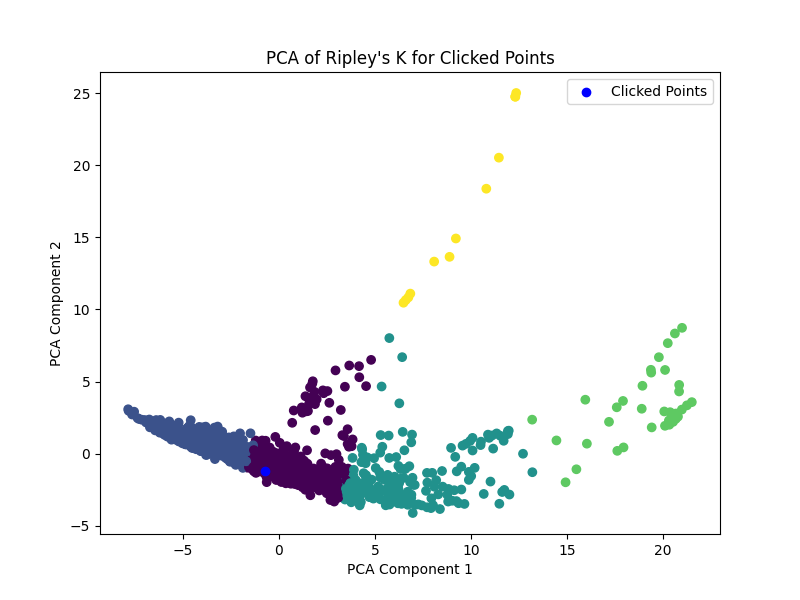

In [7]:
# Step 12: Apply PCA on the Ripley's K values for the clicked points
if points_array.shape[0] > 1:
    
    k_values_clicked_new = np.array(k_values_clicked).reshape(1, -1)  # Reshape for PCA compatibility
    xy_vals = calculate_xy_mean(points_array.flatten().reshape(1,-1))




    k_values_clicked_new = np.hstack((k_values_clicked_new, xy_vals))
  
    reduced_k_values_clicked = pca_obj_ripley.transform(k_values_clicked_new)  # Transform using the same PCA model

    # Step 13: Plot the PCA-reduced clicked points

    plt.scatter(reduced_k_values_clicked[:, 0], reduced_k_values_clicked[:, 1], c='blue', label='Clicked Points')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title("PCA of Ripley's K for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [8]:
from sklearn.neighbors import KDTree

# Step 1: Build a KDTree from the PCA-reduced real match data
tree = KDTree(np_pca_ripley)

# Step 2: Query the 10 nearest neighbors for the clicked situation
distances, indices = tree.query(reduced_k_values_clicked, k=10)  # Find 10 nearest neighbors

# Flatten the indices
closest_indices = indices.flatten()
print("Closest situation indices:", closest_indices)


Closest situation indices: [1176  488  764  368  277  342 1275  756 1175  765]


In [9]:
one_match

,Time [s],frame_team,Time [s]_team,half_team,home_1_x,home_1_y,home_3_x,home_3_y,home_4_x,home_4_y,...,away_16_y,away_17_x,away_17_y,away_22_x,away_22_y,away_23_x,away_23_y,ball_x,ball_y,Period
0,0.00,0,0.00,1H,52.49,-0.08,19.96,0.13,21.84,10.54,...,-0.28,-0.42,17.42,-0.41,28.75,-0.43,33.28,0.12,1.15,1
1,0.04,1,0.04,1H,52.51,-0.06,19.95,0.14,21.87,10.56,...,-0.29,-0.41,17.42,-0.40,28.72,-0.43,33.25,0.11,1.15,1
2,0.08,2,0.08,1H,52.53,-0.05,19.95,0.15,21.89,10.57,...,-0.30,-0.39,17.42,-0.34,28.71,-0.43,33.18,-0.59,0.95,1
3,0.12,3,0.12,1H,52.51,-0.06,19.94,0.16,21.90,10.58,...,-0.30,-0.37,17.42,-0.29,28.71,-0.41,33.06,-1.28,0.76,1
4,0.16,4,0.16,1H,52.51,-0.05,19.94,0.17,21.92,10.59,...,-0.32,-0.33,17.41,-0.23,28.67,-0.38,32.96,-1.98,0.55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69121,2764.84,69121,2764.84,1H,48.55,1.21,34.59,-4.71,33.87,-1.29,...,-0.29,26.77,17.75,34.59,-3.21,25.63,6.05,3.57,6.20,1
69122,2764.88,69122,2764.88,1H,48.61,1.25,34.59,-4.77,33.84,-1.33,...,-0.31,26.67,17.81,34.55,-3.26,25.67,6.02,3.60,6.24,1
69123,2764.92,69123,2764.92,1H,48.66,1.28,34.59,-4.83,33.82,-1.36,...,-0.32,26.58,17.87,34.54,-3.31,25.71,5.99,3.61,6.26,1
69124,2764.96,69124,2764.96,1H,48.71,1.31,34.59,-4.88,33.80,-1.39,...,-0.33,26.51,17.93,34.52,-3.36,25.74,5.96,3.62,6.26,1


In [10]:
# Retrieve the 10 closest situations from the real match with time[s] column
closest_situations = one_match.loc[closest_indices,'Time [s]']  # Select time[s] along with other columns if needed


In [11]:
# Add time step columns to the closest situations. Each index is 24 time ticks
closest_situations

1176    47.04
488     19.52
764     30.56
368     14.72
277     11.08
342     13.68
1275    51.00
756     30.24
1175    47.00
765     30.60
Name: Time [s], dtype: float64

AttributeError: 'numpy.float64' object has no attribute 'index'

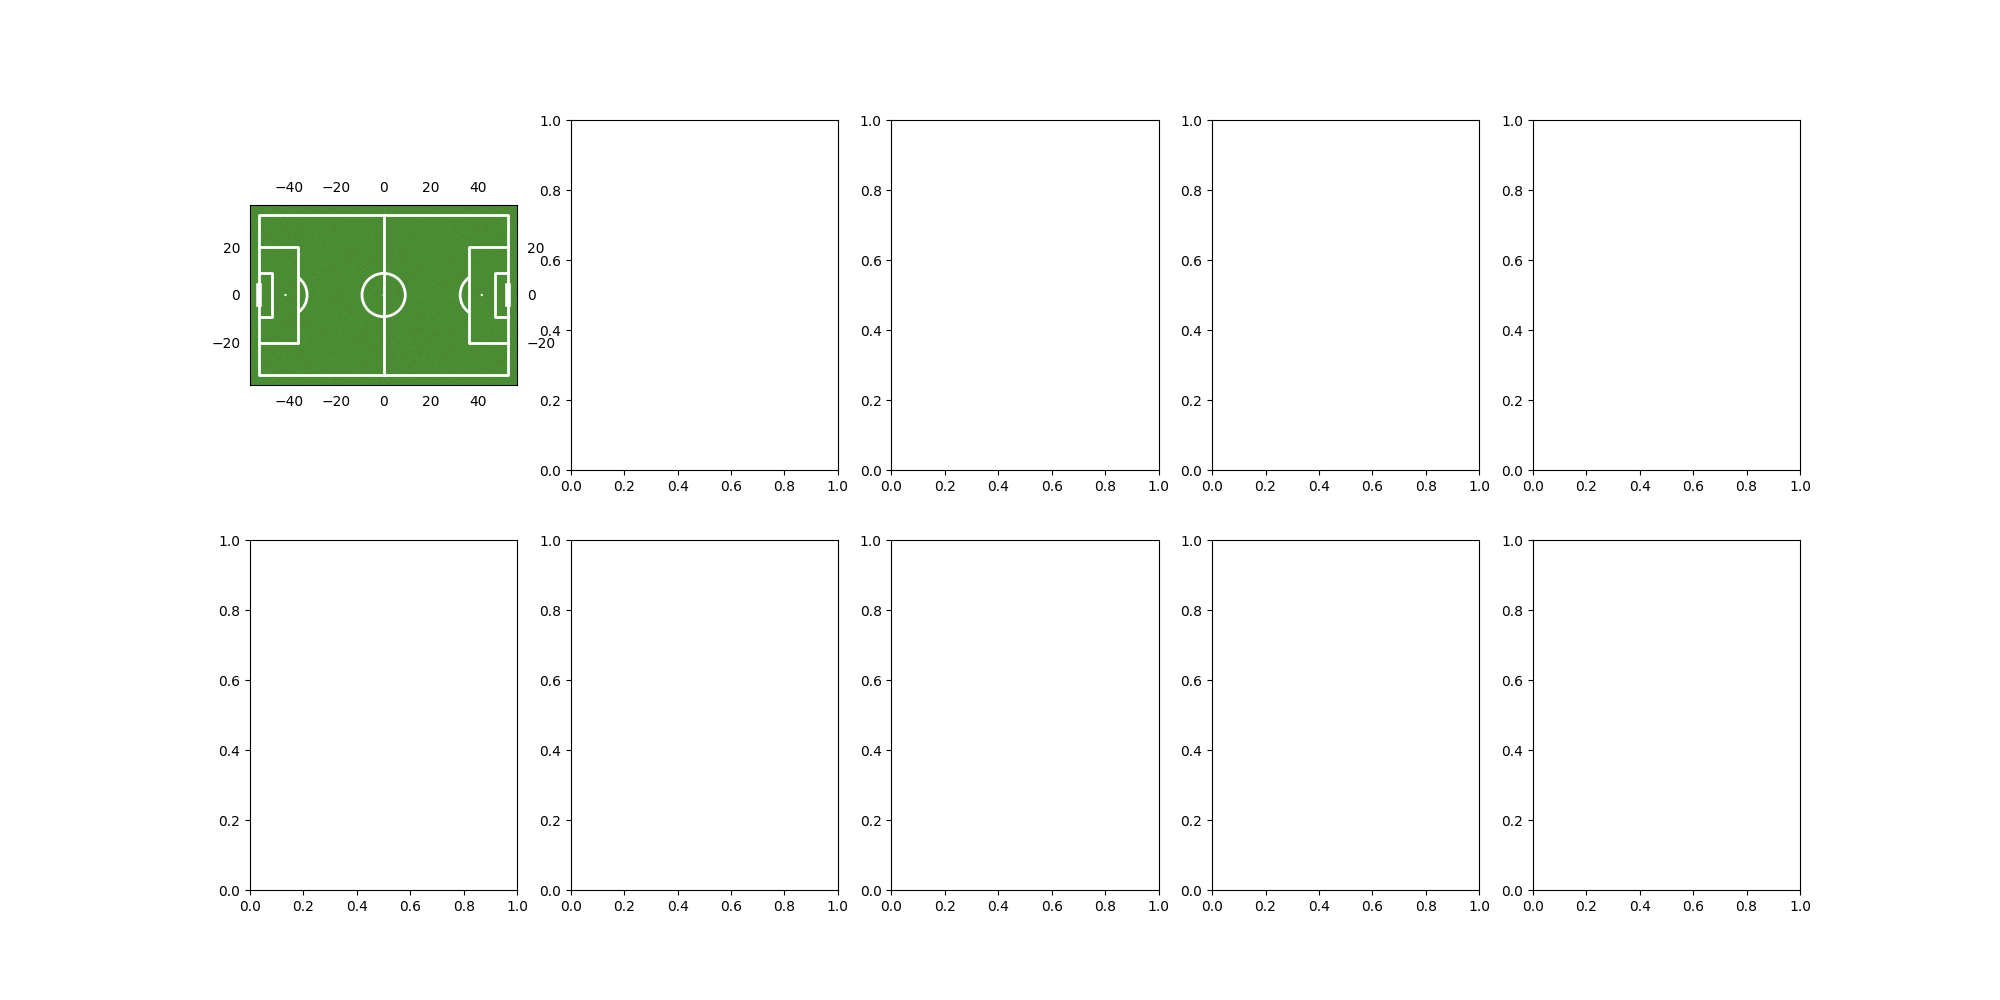

In [12]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import pandas as pd

# Function to extract player coordinates from the DataFrame
def extract_player_positions(row):
    # Extract home player positions (x and y)
    home_x_cols = [col for col in row.index if 'home' in col and '_x' in col]
    home_y_cols = [col for col in row.index if 'home' in col and '_y' in col]
    
    home_positions = [(row[x], row[y]) for x, y in zip(home_x_cols, home_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    # Extract away player positions (x and y)
    away_x_cols = [col for col in row.index if 'away' in col and '_x' in col]
    away_y_cols = [col for col in row.index if 'away' in col and '_y' in col]
    
    away_positions = [(row[x], row[y]) for x, y in zip(away_x_cols, away_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    return home_positions, away_positions

# Function to plot a single situation on the pitch
def plot_situation(row, ax):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax)
    
    # Extract player positions from the row
    home_positions, away_positions = extract_player_positions(row)
    
    # Plot home team players (red)
    for pos in home_positions:
        ax.plot(pos[0], pos[1], 'ro', label='Home Team')  # Mark home players as red dots

    # Plot away team players (blue)
    for pos in away_positions:
        ax.plot(pos[0], pos[1], 'bo', label='Away Team')  # Mark away players as blue dots
    
    ax.set_title(f"Situation at Time: {row['Time [s]']:.2f} sec")

# Step 4: Visualize the 10 closest situations on the pitch
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()

# Make sure closest_situations contains all required columns from the original DataFrame
if 'Time [s]' in closest_situations.columns:
    for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
        plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation
else:
    print("Ensure that closest_situations contains full rows, including player position columns.")

plt.tight_layout()
plt.show()


In [13]:
import vlc
import time
import tkinter as tk
from tkinter import Button, Label

# Path to your video file
video_path = "C:/Users/Ericd/OneDrive/Dokumenter/GitHub/Thesis_V1/data/video/EURO2020Russia_vs_Denmark_1st_Half_769630.mp4"

# Create a VLC instance
vlc_instance = vlc.Instance()

# Create a VLC media player
player = vlc_instance.media_player_new()

# Load the media file
media = vlc_instance.media_new(video_path)
player.set_media(media)

# Play the video initially
player.play()

# Give some time for the video to start
time.sleep(2)

# Function to seek to a specific time in seconds
def seek_to_time(player, seconds):
    # Seek to the specific time in the video (in milliseconds)
    player.set_time(int(seconds * 1000))

# Pause the video
def pause_video():
    player.pause()

# Resume the video
def play_video():
    player.play()

# Close the video
def close_video():
    player.stop()
    player.release()
    root.quit()

# Function to update the current time in the video player
def update_time_label():
    current_time = player.get_time() // 1000  # Get current time in milliseconds, convert to seconds
    time_label.config(text=f"Time: {current_time} seconds")
    root.after(1000, update_time_label)  # Update every second

# Function to skip to the next closest situation time
def next_time():
    global current_index
    current_index = (current_index + 1) % len(closest_situations)
    specific_time_in_seconds = closest_situations.iloc[current_index]
    seek_to_time(player, specific_time_in_seconds)
    time_label.config(text=f"Time: {specific_time_in_seconds} seconds")

# Function to skip to the previous closest situation time
def previous_time():
    global current_index
    current_index = (current_index - 1) % len(closest_situations)
    specific_time_in_seconds = closest_situations.iloc[current_index]
    seek_to_time(player, specific_time_in_seconds)
    time_label.config(text=f"Time: {specific_time_in_seconds} seconds")

# Create the Tkinter window
root = tk.Tk()
root.title("VLC Video Control")

# Pause Button
pause_button = Button(root, text="Pause", command=pause_video)
pause_button.pack(side=tk.LEFT)

# Play Button
play_button = Button(root, text="Play", command=play_video)
play_button.pack(side=tk.LEFT)

# Next Button
next_button = Button(root, text="Next", command=next_time)
next_button.pack(side=tk.LEFT)

# Previous Button
previous_button = Button(root, text="Previous", command=previous_time)
previous_button.pack(side=tk.LEFT)

# Close Button
close_button = Button(root, text="Close", command=close_video)
close_button.pack(side=tk.LEFT)

# Time Label
time_label = Label(root, text="Time: 0 seconds")
time_label.pack(side=tk.LEFT)

# Initialize index for closest situations
current_index = 0

# Example: Extracting the specific time from your DataFrame
specific_time_in_seconds = closest_situations.iloc[current_index]
print(specific_time_in_seconds)
seek_to_time(player, specific_time_in_seconds)

# Start updating the time label
update_time_label()

# Keep the video running
root.mainloop()


IndexError: invalid index to scalar variable.

: 